Python CVXPY を使ったハンズオン演習

In [ ]:
# sparse+++

! pip install cvxpy
! pip install ecos



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\tanak\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: C:\Users\tanak\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


status: optimal
optimal value: 4.247018912857674
非ゼロ要素の数: 10
非ゼロの係数インデックス: [  0  50  51  52  53  54  55  98  99 100]
非ゼロの係数の値: [-1.00000000e+00 -1.36100867e-06 -7.73156308e-06 -4.22730173e-01
 -5.62351873e-01 -2.38878672e-06 -1.37978462e-06  1.04427646e+00
  9.67320979e-01  8.35318821e-03]


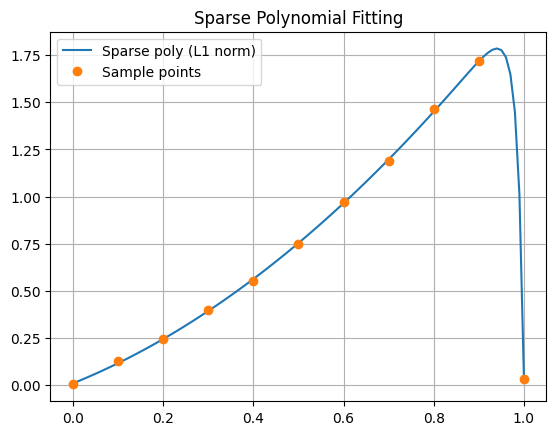

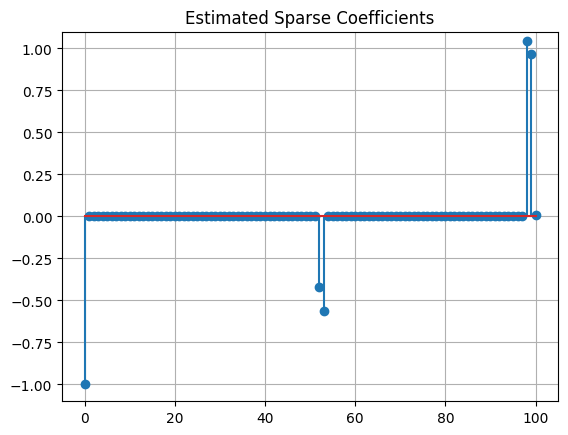

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# --- データの準備 ---
t = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
y = np.array([0.002286, 0.1261, 0.2440, 0.3950, 0.5516, 0.7502,
              0.9696, 1.189, 1.465, 1.718, 0.03243])

n = 101  # 多項式次数 + 1（x^0 ～ x^100）
Phi_e = np.vander(t, n)

# --- スパース推定（L1ノルム最小化） ---
x = cp.Variable(n)
#cost = cp.norm1(x)
cost = cp.norm1(x) + 1e1 * cp.norm2(Phi_e @ x - y)
constraints = [
    #Phi_e @ x == y,
    x <= 1.1,
    x >= -1.1,
    
    cp.norm1(x) <= 4.2
    ,
    x[0] == -1,  # x^100の係数は非ゼロ

]
prob = cp.Problem(cp.Minimize(cost), constraints)
#prob.solve(solver=cp.ECOS_BB)
prob.solve()
# --- 結果出力 ---
print("status:", prob.status)
print("optimal value:", prob.value)

# --- 推定された多項式の描画 ---
mm = 101
dd = 1/(mm-1)
time = np.arange(0, 1 + dd, dd)

if x.value is not None:
    
    fig, ax = plt.subplots()
    ax.plot(time, np.polyval(x.value, time), label='Sparse poly (L1 norm)')
    ax.plot(t, y, 'o', label='Sample points')
    ax.legend()
    ax.grid()
    ax.set_title("Sparse Polynomial Fitting")
    if x.value is not None:
        nonzero_indices = np.flatnonzero(np.abs(x.value) > 1e-6)  # 小さな値を無視
        
        nonzero_values = x.value[nonzero_indices]

    print("非ゼロ要素の数:", len(nonzero_indices))
    print("非ゼロの係数インデックス:", nonzero_indices)
    print("非ゼロの係数の値:", nonzero_values)

    # --- 推定された係数の表示 ---
    plt.figure()
    plt.stem(x.value)
    plt.ylim(-1.1, 1.1)
    plt.title("Estimated Sparse Coefficients")
    plt.grid()
    plt.show()
else:
    print("最適化が失敗しました。x.value is None")


選ばれたインデックス: [ 0 99 98 53]
選ばれた係数の値: [-1.          0.96732098  1.04427646 -0.56235187]


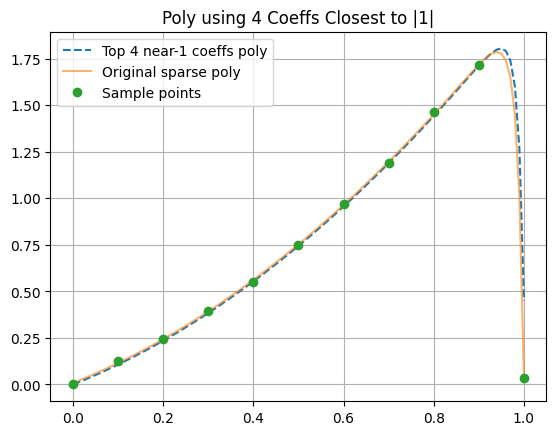

選ばれたインデックス: [ 0 99 98 53]
選ばれた係数の値: [-1.          0.96732098  1.04427646 -0.56235187]


In [2]:
if x.value is not None:
    # --- 絶対値が1に近い4つの係数を選択 ---
    abs_diff = np.abs(np.abs(x.value) - 1)  # |係数|と1の差
    top4_indices = np.argsort(abs_diff)[:4]  # 差が小さい順に4つ

    # 新しい係数ベクトル（他はゼロ）
    sparse_x = np.zeros_like(x.value)
    sparse_x[top4_indices] = x.value[top4_indices]

    print("選ばれたインデックス:", top4_indices)
    print("選ばれた係数の値:", x.value[top4_indices])   
    # --- 再構築された多項式の描画 ---
    fig, ax = plt.subplots()
    ax.plot(time, np.polyval(sparse_x, time), label='Top 4 near-1 coeffs poly', linestyle='--')
    ax.plot(time, np.polyval(x.value, time), label='Original sparse poly', alpha=0.6)
    ax.plot(t, y, 'o', label='Sample points')
    ax.legend()
    ax.grid()
    ax.set_title("Poly using 4 Coeffs Closest to |1|")
    plt.show()

    print("選ばれたインデックス:", top4_indices)
    print("選ばれた係数の値:", x.value[top4_indices])
